In [1]:
from datetime import datetime

import dataset_utils as dataset
import torch as t
from ML_cup.pytorch import *
from ML_cup.dataset_utils import CupDataset


In [2]:
import os

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    torch.set_default_device(torch.device("cuda"))
print(f"Using device: {torch.cuda.current_device()}")
print(f"Available cpu count: {os.cpu_count()}")

GPU is available
Using device: 0
Available cpu count: 16


In [3]:
dev_data = dataset.load_dataset("../data/ML-CUP24-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP24-TS.csv")

In [4]:
import time

# get a seed for the random state based on the current time
rand = int(time.time())
print(f"Random seed: {rand}")
np.random.seed(rand)

Random seed: 1740908541


In [5]:
# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders, dev_loader, test_loader = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=0,
                                                                           random_state=rand)
blind_loader = DataLoader(CupDataset(blind_data, device=torch.device('cuda')), batch_size=None)


# Model Definitions

In [6]:
def MLP() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 3)
    )


def MLPr() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 200),
        t.nn.ReLU(),
        t.nn.Linear(200, 200),
        t.nn.ReLU(),
        t.nn.Linear(200, 3)
    )


def MLPv2() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 3)
    )


def MLPv3() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 100),
        t.nn.Tanh(),
        t.nn.Linear(100, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 3)
    )


def MLPv4() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 50),
        t.nn.Tanh(),
        t.nn.Linear(50, 50),
        t.nn.Tanh(),
        t.nn.Linear(50, 3)
    )

# Grid search for the best parameters

# Model v1

In [7]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': np.linspace(0.0075, 0.00075, 5),
        'weight_decay': np.linspace(0.01, 0.00001, 10),
        'momentum': [0.9, 0.95, 0.8],
        'nesterov': [True, False]
    }
]

In [8]:
# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLP, parameters=parameters, random_seed=rand,
                                              train_loader=train_loaders,
                                              val_loader=val_loaders, max_epochs=300,
                                              scheduler=('', {}),
                                              stability_threshold=0.25, patience=10,
                                              clip=1.0,
                                              tensorboard_folder_base=f'runs/batched/MLP/SGD/tanh/{rand}')

Avg Train MEE: 6.1717428207397464, Avg Val MEE: 3.7362449169158936, Avg Fluctuation: 0.07823304595103664
('SGD', {'lr': 0.0075, 'weight_decay': 0.00889, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 6.162718296051025, Avg Val MEE: 3.7255130290985106, Avg Fluctuation: 0.08179402449126763
('SGD', {'lr': 0.0075, 'weight_decay': 0.0077800000000000005, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 6.010269832611084, Avg Val MEE: 3.697077512741089, Avg Fluctuation: 0.07624854272274623
('SGD', {'lr': 0.0075, 'weight_decay': 0.01, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 8.203707504272462, Avg Val MEE: 4.269217538833618, Avg Fluctuation: 0.1309213190719861
('SGD', {'lr': 0.0075, 'weight_decay': 0.00889, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 8.133990955352782, Avg Val MEE: 4.225061082839966, Avg Fluctuation: 0.13148639951433455
('SGD', {'lr': 0.0075, 'weight_decay': 0.0077800000000000005, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Tr

{'lr': 7.5e-05, 'weight_decay': 1e-05, 'momentum': 0.8, 'nesterov': False, 'optimizer': 'SGD'} Sequential(
  (0): Linear(in_features=12, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): Tanh()
  (4): Linear(in_features=200, out_features=3, bias=True)
)
Evaluating the model on the test set
0.8544418811798096


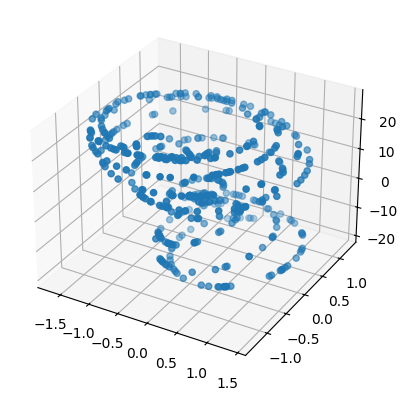

array([[-2.1037495e-01, -9.2438996e-01,  2.3276600e+01],
       [-5.0652194e-01,  7.9893905e-01,  2.3708302e+01],
       [ 1.2791859e+00,  2.3634873e-02, -1.5423914e+01],
       ...,
       [ 3.1344059e-01, -7.7237934e-01,  2.3879463e+01],
       [ 2.4460305e-01,  7.9877806e-01, -7.6246662e+00],
       [ 8.3781607e-02,  2.8607613e-01, -2.7273133e+00]], dtype=float32)

In [9]:
print(best_pytorch_params, best_model)
model_v1 = best_model
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v1, test_loader))

blind_test(model_v1, blind_loader, rand)

In [10]:
parameters = [
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.0005, 0.0001, 10),
        'weight_decay': np.linspace(0.001, 0.00001, 10),
    }]

In [11]:
# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLP, parameters=parameters, random_seed=rand,
                                              train_loader=train_loaders,
                                              val_loader=val_loaders, max_epochs=300,
                                              scheduler=('', {}),
                                              stability_threshold=0.25, patience=10,
                                              clip=1.0,
                                              tensorboard_folder_base=f'runs/batched/MLP/Adam/tanh/{rand}')

Avg Train MEE: 0.3500470757484436, Avg Val MEE: 0.814645791053772, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0005, 'weight_decay': 0.00034}, 1.0)
Avg Train MEE: 0.3473141372203827, Avg Val MEE: 0.8108149409294129, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0005, 'weight_decay': 0.0008900000000000001}, 1.0)
Avg Train MEE: 0.3567530274391174, Avg Val MEE: 0.819362735748291, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0005, 'weight_decay': 0.00022999999999999995}, 1.0)
Avg Train MEE: 0.35382118821144104, Avg Val MEE: 0.8146652460098267, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0005, 'weight_decay': 0.00056}, 1.0)
Avg Train MEE: 0.35204872488975525, Avg Val MEE: 0.8195756077766418, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0005, 'weight_decay': 0.00011999999999999999}, 1.0)
Avg Train MEE: 0.35625038146972654, Avg Val MEE: 0.8253573179244995, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0005, 'weight_decay': 0.00067}, 1.0)
Avg Train MEE: 0.35801743268966674, Avg Val MEE: 0.8237268805503846, Avg Fluctuation: 0.0
(

{'lr': 0.0001, 'weight_decay': 1e-05, 'optimizer': 'Adam'} Sequential(
  (0): Linear(in_features=12, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): Tanh()
  (4): Linear(in_features=200, out_features=3, bias=True)
)
Evaluating the model on the test set
0.7727375030517578


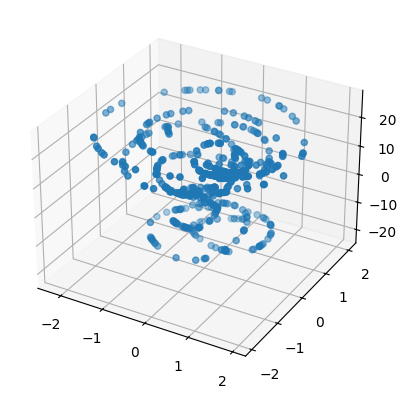

array([[  0.8946633 ,  -1.2789965 ,  24.841908  ],
       [  0.38213673,   0.8959086 ,  23.350222  ],
       [  1.0234836 ,   0.559441  , -16.568567  ],
       ...,
       [  1.3835727 ,  -1.3453377 ,  25.332628  ],
       [  0.22488907,   0.7948303 ,  -7.818428  ],
       [  0.20545313,   0.11047944,  -2.8123047 ]], dtype=float32)

In [12]:
print(best_pytorch_params, best_model)
model_v1 = best_model
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v1, test_loader))

blind_test(model_v1, blind_loader, rand)

# Model v2

In [11]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': [0.0075, 0.005, 0.025],
        'weight_decay': [0.001, 0.005, 0.0015, 0.0025],
        'momentum': [0.9, 0.95],
        'nesterov': [True, False]
    },
    {
        'optimizer': 'Adam',
        'lr': [0.00075, 0.0005, 0.0003, 0.0001],
        'weight_decay': [0.0, 0.001, 0.0005]
    }
]
# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLPv2, parameters=parameters, train_loader=train_loaders,
                                              val_loader=val_loaders, scheduler=('', {}),
                                              patience=20, clip=1.0, stability_threshold=0.2,
                                              tensorboard_folder_base=f'runs/batched/MLP2/tanh/{rand}',
                                              random_seed=rand)

Avg Train MEE: 3.9200844287872316, Avg Val MEE: 2.99623761177063, Avg Fluctuation: 0.08144096001962416
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 2.978811168670654, Avg Val MEE: 2.5412104606628416, Avg Fluctuation: 0.12125441691568144
('SGD', {'lr': 0.0075, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 2.5778369665145875, Avg Val MEE: 2.3639944791793823, Avg Fluctuation: 0.04371071576288123
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 2.927689266204834, Avg Val MEE: 2.5312344789505006, Avg Fluctuation: 0.11722036868671878
('SGD', {'lr': 0.0075, 'weight_decay': 0.0015, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 2.7579483509063722, Avg Val MEE: 2.456234836578369, Avg Fluctuation: 0.11790020844433342
('SGD', {'lr': 0.0075, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 1.9261654257774352, A

{'lr': 0.0001, 'weight_decay': 0.0005, 'optimizer': 'Adam'} Sequential(
  (0): Linear(in_features=12, out_features=300, bias=True)
  (1): Tanh()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): Tanh()
  (4): Linear(in_features=300, out_features=3, bias=True)
)
Evaluating the model on the test set
0.7262372970581055


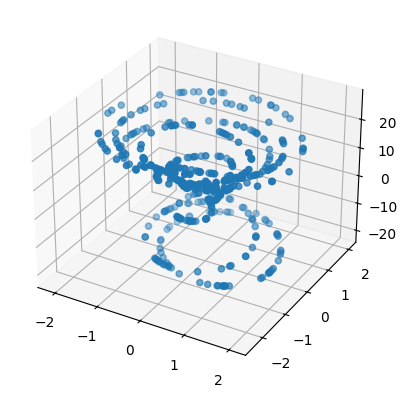

array([[  0.83807147,  -2.3838072 ,  24.179686  ],
       [ -0.17379373,   1.2391199 ,  22.817036  ],
       [  1.7166643 ,  -0.34173483, -16.937166  ],
       ...,
       [  1.3809636 ,  -2.1327999 ,  25.281292  ],
       [  0.09514315,   0.8753912 ,  -7.6576886 ],
       [  0.03010809,   0.11532259,  -2.6432147 ]], dtype=float32)

In [12]:
# retrain the model with the best parameters
#best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params, best_model)
model_v2 = best_model

# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v2, test_loader))

blind_test(model_v2, blind_loader, rand)

# Model v3

In [12]:
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLPv3, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders,
                                  scheduler=('', {}),
                                  clip=1.5, max_epochs=500,
                                  stability_threshold=0.5, patience=20,
                                  tensorboard_folder_base=f'runs/batched//MLP3_s2/{datetime.now().strftime("%Y-%m-%d_%H-%M")}_{rand}',
                                  random_seed=rand)

Avg Train MEE: 1.8614007472991942, Avg Val MEE: 1.9197764158248902, Avg Fluctuation: 0.1621376890696596
('SGD', {'lr': 0.0075, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': False}, 1.5)
Avg Train MEE: 3.573005110025406, Avg Val MEE: 2.631524658203125, Avg Fluctuation: 0.12163632232618096
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': False}, 1.5)
Avg Train MEE: 1.7848498821258545, Avg Val MEE: 1.8576168775558473, Avg Fluctuation: 0.16428397084670937
('SGD', {'lr': 0.0075, 'weight_decay': 0.005, 'momentum': 0.95, 'nesterov': False}, 1.5)
Avg Train MEE: 1.7659428477287293, Avg Val MEE: 1.826720368862152, Avg Fluctuation: 0.1497368789744397
('SGD', {'lr': 0.0075, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': False}, 1.5)
Avg Train MEE: 0.5445804178714753, Avg Val MEE: 1.1159853339195251, Avg Fluctuation: 0.06624400446117937
('SGD', {'lr': 0.0075, 'weight_decay': 0.0015, 'momentum': 0.95, 'nesterov': True}, 1.5)
Avg Train MEE: 0.9180117726325989, 

({'lr': 0.0001, 'weight_decay': 0.0005, 'optimizer': 'Adam'}, Sequential(
  (0): Linear(in_features=12, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=200, bias=True)
  (3): Tanh()
  (4): Linear(in_features=200, out_features=300, bias=True)
  (5): Tanh()
  (6): Linear(in_features=300, out_features=3, bias=True)
))
Evaluating the model on the test set
0.7628082036972046


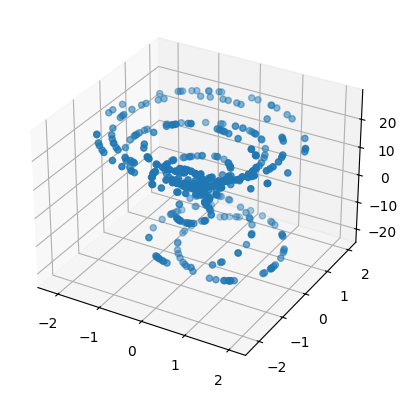

array([[ 6.17352605e-01, -2.19587016e+00,  2.34216003e+01],
       [-3.60733807e-01,  1.40528274e+00,  2.27526588e+01],
       [ 1.68236017e+00, -9.90733430e-02, -1.73584442e+01],
       ...,
       [ 1.34452510e+00, -1.92119479e+00,  2.47331505e+01],
       [ 4.59438041e-02,  9.34785068e-01, -8.43009663e+00],
       [-8.53376742e-03,  1.04569085e-01, -2.67674422e+00]], dtype=float32)

In [13]:
# retrain the model with the best parameters
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)
model_v3 = best_model

# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v3, test_loader))

blind_test(model_v3, blind_loader, rand)

# CUP TEST

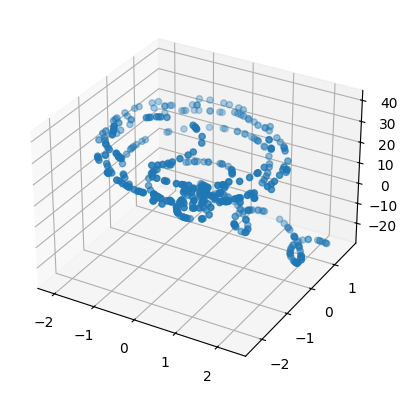

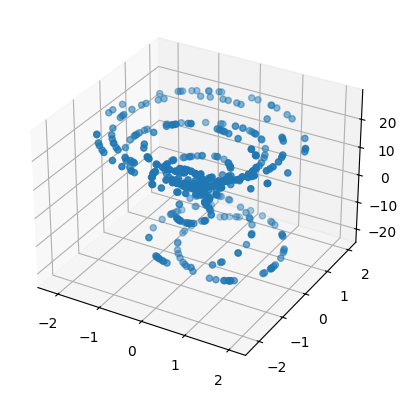

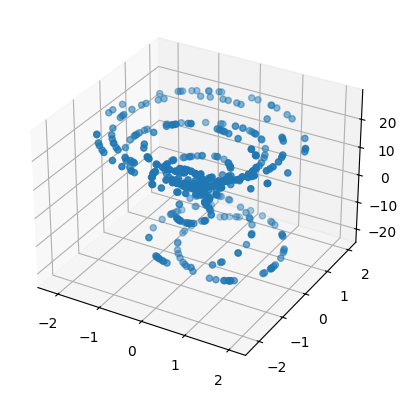

array([[ 6.17352605e-01, -2.19587016e+00,  2.34216003e+01],
       [-3.60733807e-01,  1.40528274e+00,  2.27526588e+01],
       [ 1.68236017e+00, -9.90733430e-02, -1.73584442e+01],
       ...,
       [ 1.34452510e+00, -1.92119479e+00,  2.47331505e+01],
       [ 4.59438041e-02,  9.34785068e-01, -8.43009663e+00],
       [-8.53376742e-03,  1.04569085e-01, -2.67674422e+00]], dtype=float32)

In [14]:
blind_test(model_v1, blind_loader, rand)
blind_test(model_v2, blind_loader, rand)
blind_test(model_v3, blind_loader, rand)